In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['german_credit_data.csv']


<h1>Introduction:</h1>
<p>The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

<h1>Content</h1>
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:
<div>
<p>Age (numeric)
<p>Sex (text: male, female)
<p>Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
<p>Housing (text: own, rent, or free)
<p>Saving accounts (text - little, moderate, quite rich, rich)
<p>Checking account (numeric, in DM - Deutsch Mark)
<p>Credit amount (numeric, in DM)
<p>Duration (numeric, in month)
<p>Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
<p>Risk (Value target - Good or Bad Risk)

<h1>load Modules</h1>

In [2]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

#Importing the data
df = pd.read_csv("../input/german_credit_data.csv",index_col=0)

In [3]:

# Other Libraries
#from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [4]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

In [5]:

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [7]:
df.describe(include=["O"])

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
count,1000,1000,817,606,1000,1000
unique,2,3,4,3,8,2
top,male,own,little,little,car,good
freq,690,713,603,274,337,700


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [9]:
df.shape

(1000, 10)

In [10]:
df.columns.values

array(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype=object)

In [11]:
print("Total number of case: {}".format(df.shape[0]))
print("Number of high Risk: {}".format(df[df.Risk == "bad"].shape[0]))
print("Number of low Risk: {}".format(df[df.Risk == "good"].shape[0]))

Total number of case: 1000
Number of high Risk: 300
Number of low Risk: 700


Text(0.5, 1.0, 'Class Distributions \n ( No Risk ||  Risk)')

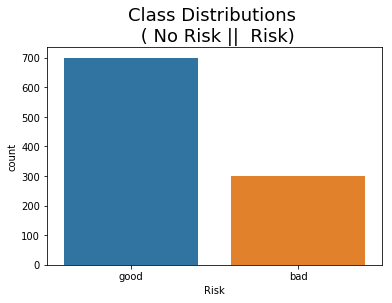

In [12]:
sns.countplot('Risk', data=df)
plt.title('Class Distributions \n ( No Risk ||  Risk)', fontsize=18)

In [13]:
# it's a library that we work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features


trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

In [14]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



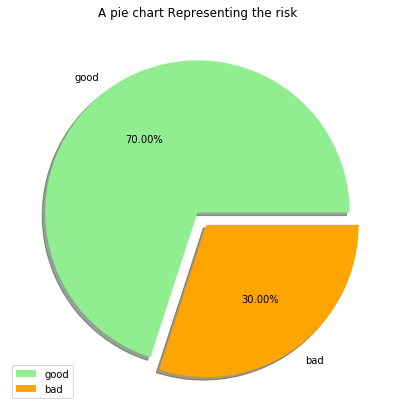

In [15]:
labels = ['good','bad']
size = df['Risk'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('A pie chart Representing the risk')
plt.axis('off')
plt.legend()
plt.show()

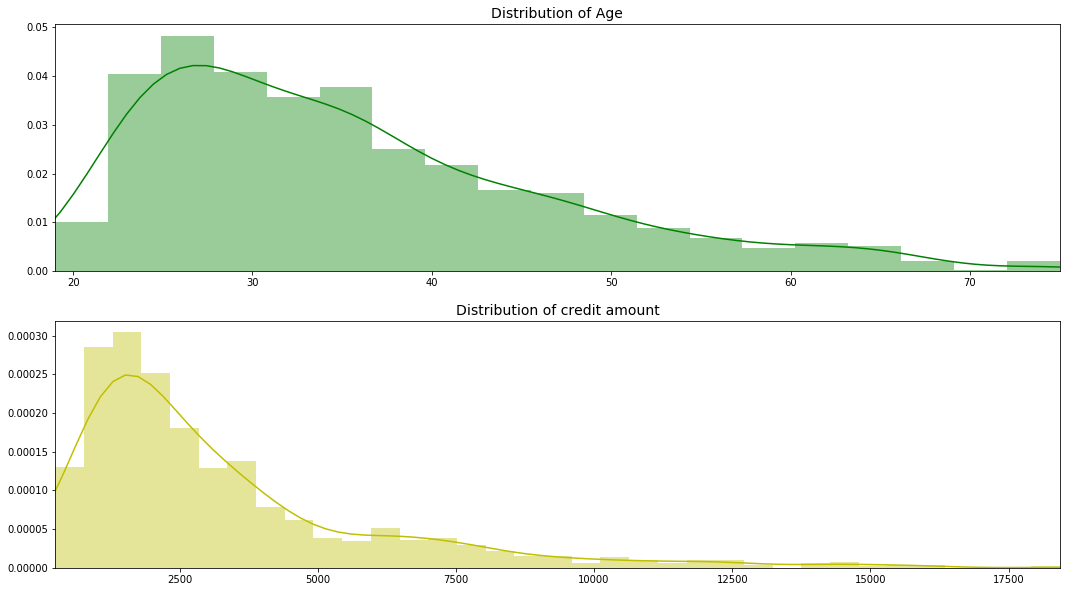

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(18,10))

amount_val = df['Age'].values
time_val = df['Credit amount'].values

sns.distplot(amount_val, ax=ax[0], color='g')
ax[0].set_title('Distribution of Age', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='y')
ax[1].set_title('Distribution of credit amount', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Risk', axis=1)
y = df['Risk']
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
    
    # Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [193 196 198 200 201 202 204 205 206 207 208 209 210 211 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379
 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433
 434 435 436 437 438 439 440 441 442 443 444

In [18]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
bad_df = df.loc[df['Risk'] == "bad"]
good_df = df.loc[df['Risk'] == "good"][:300]

normal_distributed_df = pd.concat([bad_df, good_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
120,25,female,2,own,little,little,1835,21,radio/TV,bad
670,27,male,1,own,moderate,NaN,4139,24,business,good
61,50,male,2,own,NaN,moderate,1537,15,radio/TV,good
640,27,female,0,own,little,little,750,18,education,bad
435,25,male,2,own,NaN,moderate,1484,12,radio/TV,bad


Distribution of the Classes in the subsample dataset
good    0.5
bad     0.5
Name: Risk, dtype: float64


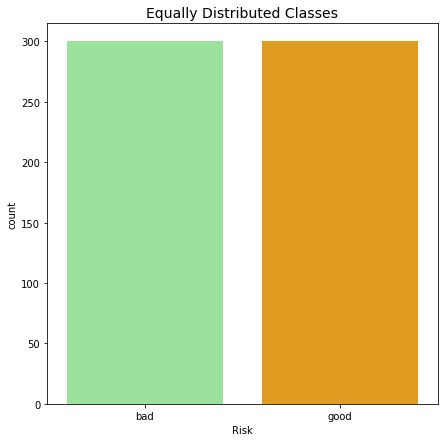

In [19]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Risk'].value_counts()/len(new_df))



sns.countplot('Risk', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

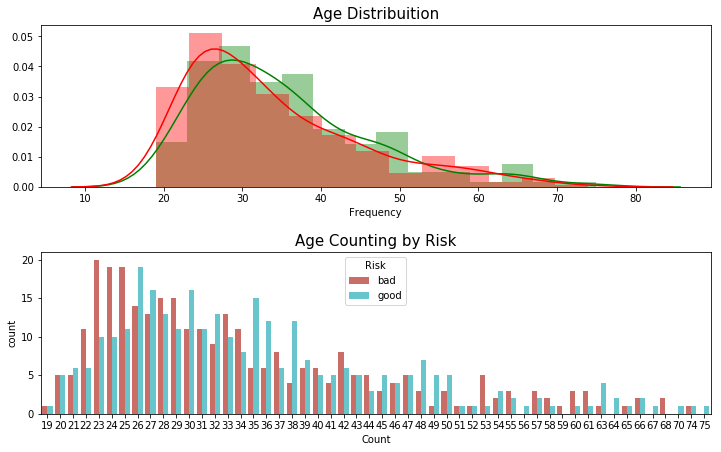

In [20]:
df_good = new_df[new_df["Risk"] == 'good']
df_bad = new_df[new_df["Risk"] == 'bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.distplot(df_good["Age"], ax=ax[0], 
             color="g")
g1 = sns.distplot(df_bad["Age"], ax=ax[0], 
             color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=new_df, 
              palette="hls", ax=ax[1], 
              hue = "Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

In [21]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
new_df["Age_cat"] = pd.cut(new_df.Age, interval, labels=cats)


df_good = new_df[new_df["Risk"] == 'good']
df_bad = new_df[new_df["Risk"] == 'bad']

In [22]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [23]:
#First plot
trace0 = go.Bar(
    x = new_df[new_df["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = new_df[new_df["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = new_df[new_df["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = new_df[new_df["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

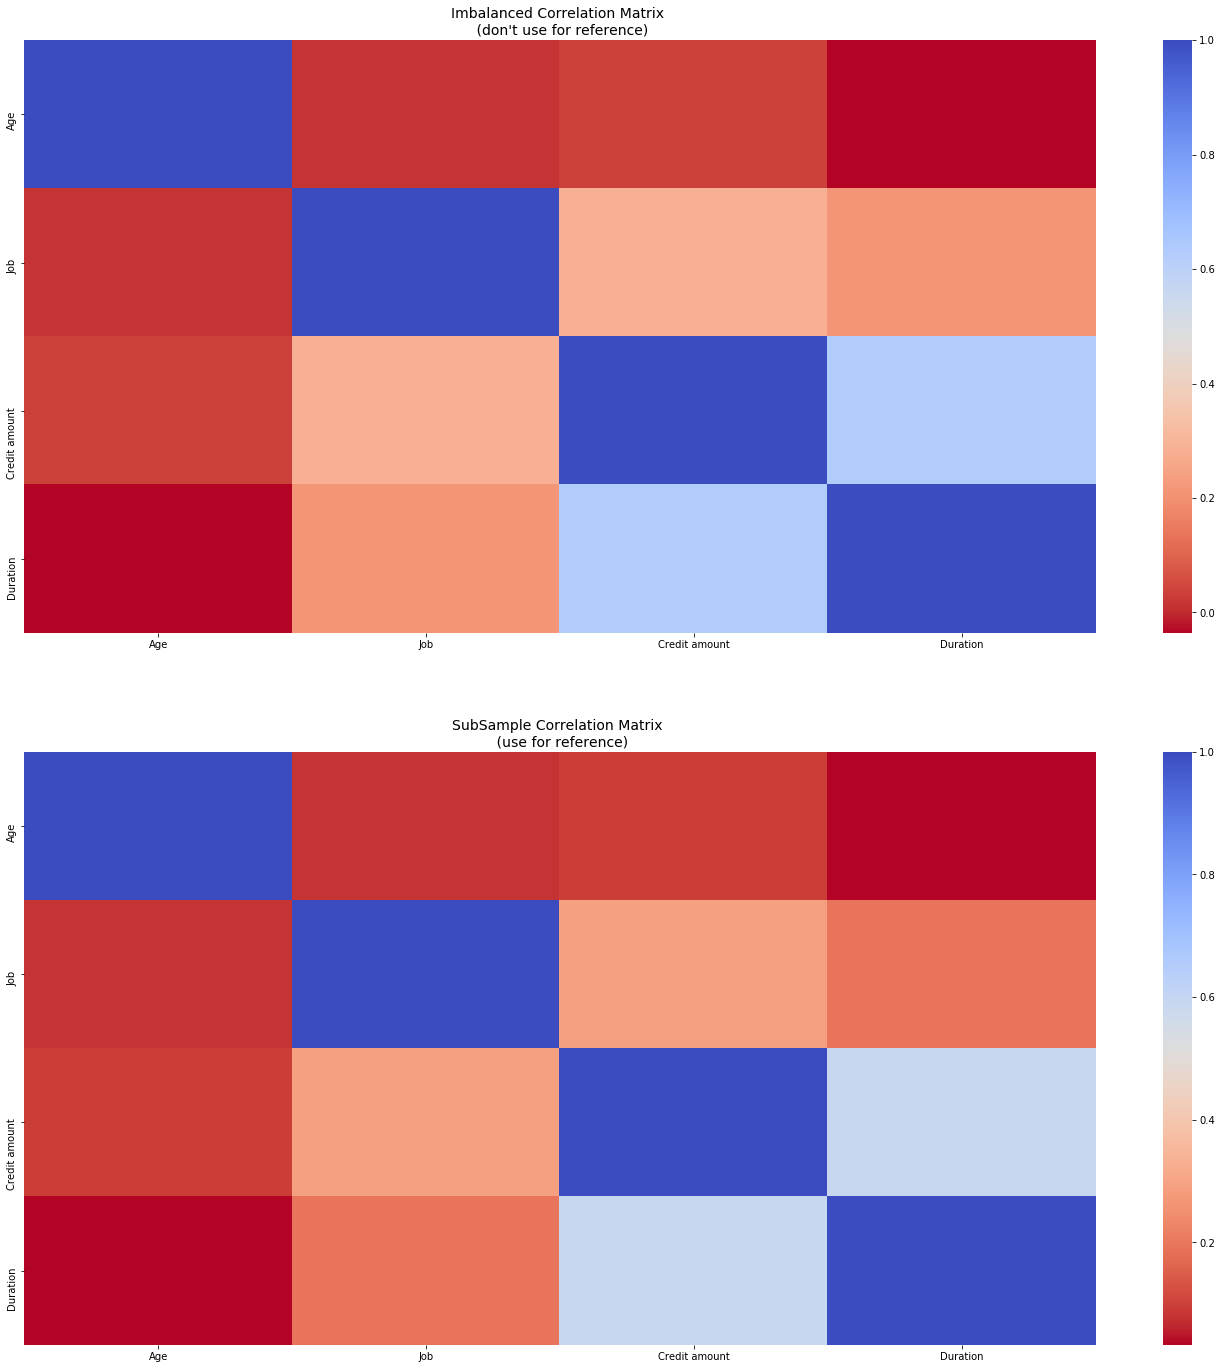

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,24))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

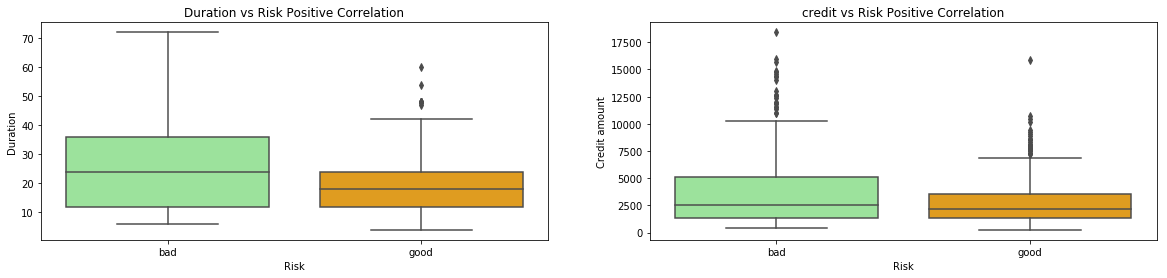

In [25]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Risk", y="Duration", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('Duration vs Risk Positive Correlation')

sns.boxplot(x="Risk", y="Credit amount", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('credit vs Risk Positive Correlation')

plt.show()

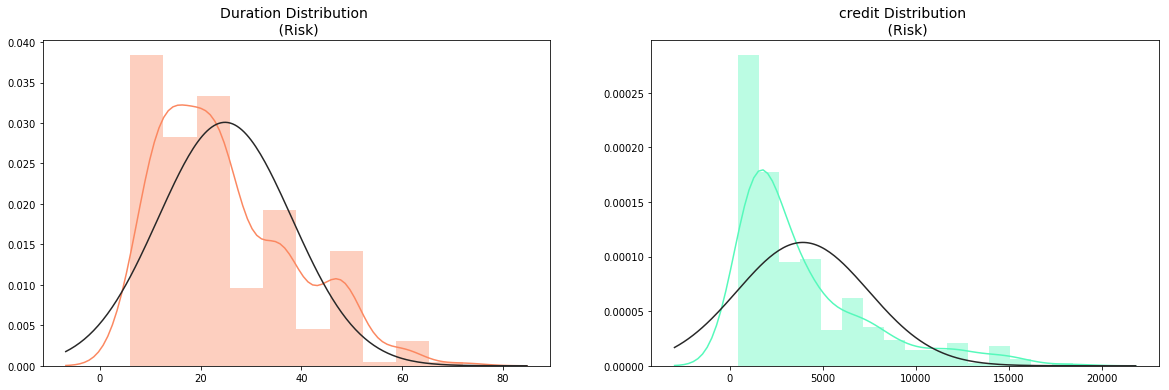

In [26]:
from scipy.stats import norm

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

Duration_Risk_dist = new_df['Duration'].loc[new_df['Risk'] == "bad"].values
sns.distplot(Duration_Risk_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Duration Distribution \n (Risk)', fontsize=14)

credit_risk_dist = new_df['Credit amount'].loc[new_df['Risk'] == "bad"].values
sns.distplot(credit_risk_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('credit Distribution \n (Risk)', fontsize=14)

plt.show()

In [27]:
    # Undersampling before cross validating (prone to overfit)

X = new_df.drop('Risk', axis=1)
X=pd.get_dummies(X)
y = new_df['Risk']

In [28]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [30]:

# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [31]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 68.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 55.00000000000001 % accuracy score
Classifiers:  SVC Has a training score of 52.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 59.0 % accuracy score


we will improve it further.